In [1]:
import importlib.util
import os


def is_running_in_colab()->bool:
    return 'COLAB_RELEASE_TAG' in os.environ

def is_library_installed(library_name):
    spec = importlib.util.find_spec(library_name)
    return spec is not None


In [2]:
%%capture

if not is_library_installed('kwave'):
    %pip install k-wave-python

if is_running_in_colab():
    !wget https://raw.githubusercontent.com/waltsims/k-wave-python/master/examples/us_bmode_linear_transducer/example_utils.py

In [3]:
import logging

import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from example_utils import download_if_does_not_exist

from kwave.data import Vector
from kwave.kgrid import kWaveGrid
from kwave.kmedium import kWaveMedium
from kwave.kspaceFirstOrder3D import kspaceFirstOrder3D
from kwave.ktransducer import NotATransducer, kWaveTransducerSimple
from kwave.options.simulation_execution_options import SimulationExecutionOptions
from kwave.options.simulation_options import SimulationOptions
from kwave.reconstruction.beamform import envelope_detection
from kwave.reconstruction.tools import log_compression
from kwave.utils.conversion import db2neper
from kwave.utils.dotdictionary import dotdict
from kwave.utils.filters import gaussian_filter
from kwave.utils.signals import get_win, tone_burst

SENSOR_DATA_GDRIVE_ID = '1lGFTifpOrzBYT4Bl_ccLu_Kx0IDxM0Lv'
PHANTOM_DATA_GDRIVE_ID = '1ZfSdJPe8nufZHz0U9IuwHR4chaOGAWO4'
PHANTOM_DATA_PATH = 'phantom_data.mat'

# simulation settings
DATA_CAST = 'single'
RUN_SIMULATION = True

In [4]:
pml_size_points = Vector([20, 10, 10])  # [grid points]
grid_size_points = Vector([256, 128, 128]) - 2 * pml_size_points  # [grid points]
grid_size_meters = 40e-3  # [m]
grid_spacing_meters = grid_size_meters / Vector([grid_size_points.x, grid_size_points.x, grid_size_points.x])

c0 = 1540
rho0 = 1000
source_strength = 1e6  # [Pa]
tone_burst_freq = 1.5e6  # [Hz]
tone_burst_cycles = 4
number_scan_lines = 96

In [5]:
kgrid = kWaveGrid(grid_size_points, grid_spacing_meters)
t_end = (grid_size_points.x * grid_spacing_meters.x) * 2.2 / c0  # [s]
kgrid.makeTime(c0, t_end=t_end)


(Vector([[0.00000000e+00, 3.60750361e-08, 7.21500722e-08, ...,
          5.71067821e-05, 5.71428571e-05, 5.71789322e-05]]),
 Vector(3.60750361e-08))

In [6]:
input_signal = tone_burst(1 / kgrid.dt, tone_burst_freq, tone_burst_cycles)
input_signal = (source_strength / (c0 * rho0)) * input_signal

In [7]:
medium = kWaveMedium(
    sound_speed=None,  # will be set later
    alpha_coeff=0.75,
    alpha_power=1.5,
    BonA=6
)

In [8]:
transducer = dotdict()
transducer.number_elements = 32  # total number of transducer elements
transducer.element_width = 2  # width of each element [grid points/voxels]
transducer.element_length = 24  # length of each element [grid points/voxels]
transducer.element_spacing = 0  # spacing (kerf  width) between the elements [grid points/voxels]
transducer.radius = float('inf')  # radius of curvature of the transducer [m]

# calculate the width of the transducer in grid points
transducer_width = transducer.number_elements * transducer.element_width + (
        transducer.number_elements - 1) * transducer.element_spacing

# use this to position the transducer in the middle of the computational grid
transducer.position = np.round([
    1,
    grid_size_points.y / 2 - transducer_width / 2,
    grid_size_points.z / 2 - transducer.element_length / 2
])
transducer = kWaveTransducerSimple(kgrid, **transducer)

In [9]:
not_transducer = dotdict()
not_transducer.sound_speed = c0  # sound speed [m/s]
not_transducer.focus_distance = 20e-3  # focus distance [m]
not_transducer.elevation_focus_distance = 19e-3  # focus distance in the elevation plane [m]
not_transducer.steering_angle = 0  # steering angle [degrees]
not_transducer.transmit_apodization = 'Hanning'
not_transducer.receive_apodization = 'Rectangular'
not_transducer.active_elements = np.ones((transducer.number_elements, 1))
not_transducer.input_signal = input_signal

not_transducer = NotATransducer(transducer, kgrid, **not_transducer)

In [10]:
logging.log(logging.INFO, "Fetching phantom data...")
download_if_does_not_exist(PHANTOM_DATA_GDRIVE_ID, PHANTOM_DATA_PATH)

phantom = scipy.io.loadmat(PHANTOM_DATA_PATH)
sound_speed_map = phantom['sound_speed_map']
density_map = phantom['density_map']

logging.log(logging.INFO, f"RUN_SIMULATION set to {RUN_SIMULATION}")

Downloading...
From: https://drive.google.com/uc?export=download&confirm=t&id=1ZfSdJPe8nufZHz0U9IuwHR4chaOGAWO4
To: /content/phantom_data.mat
100%|██████████| 99.1M/99.1M [00:04<00:00, 20.6MB/s]


In [11]:
# preallocate the storage set medium position
scan_lines = np.zeros((number_scan_lines, kgrid.Nt))
medium_position = 0

for scan_line_index in range(0, number_scan_lines):

    # load the current section of the medium
    medium.sound_speed = \
        sound_speed_map[:, medium_position:medium_position + grid_size_points.y, :]
    medium.density = density_map[:, medium_position:medium_position + grid_size_points.y, :]

    # set the input settings
    input_filename = f'example_input_{scan_line_index}.h5'
    # set the input settings
    simulation_options = SimulationOptions(
        pml_inside=False,
        pml_size=pml_size_points,
        data_cast=DATA_CAST,
        data_recast=True,
        save_to_disk=True,
        input_filename=input_filename,
        save_to_disk_exit=False
    )
    # run the simulation
    if RUN_SIMULATION:
        sensor_data = kspaceFirstOrder3D(
            medium=medium,
            kgrid=kgrid,
            source=not_transducer,
            sensor=not_transducer,
            simulation_options=simulation_options,
            execution_options=SimulationExecutionOptions(is_gpu_simulation=True)
        )

        scan_lines[scan_line_index, :] = not_transducer.scan_line(not_transducer.combine_sensor_data(sensor_data['p'].T))

    # update medium position
    medium_position = medium_position + transducer.element_width

if RUN_SIMULATION:
    simulation_data = scan_lines
    scipy.io.savemat('sensor_data.mat', {'sensor_data_all_lines': simulation_data})

else:
    logging.log(logging.INFO, "Downloading data from remote server...")
    sensor_data_path = 'sensor_data.mat'
    download_if_does_not_exist(SENSOR_DATA_GDRIVE_ID, sensor_data_path)

    simulation_data = scipy.io.loadmat(sensor_data_path)['sensor_data_all_lines']


scan_lines = simulation_data

┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Selected GPU device id:                                     0 │
│ GPU device name:                                     Tesla T4 │
│ Number of CPU threads:                                      2 │
│ Processor name:                Intel(R) Xeon(R) CPU @ 2.00GHz │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                            256 x 128 x 128 │
│ Medium type:                                               3D │
│ Simulation time steps:                                   1586 │
├───────────────────────────────────────────────────────────────┤
│         

KeyboardInterrupt: 

## PROCESS THE RESULTS
### Remove Input Signal


In [12]:
# Trim the delay offset from the scan line data
tukey_win, _ = get_win(kgrid.Nt * 2, 'Tukey', False, 0.05)
transmit_len = len(input_signal.squeeze())
scan_line_win = np.concatenate((np.zeros([1, transmit_len * 2]), tukey_win.T[:, :kgrid.Nt - transmit_len * 2]), axis=1)

scan_lines = scan_lines * scan_line_win

# store intermediate results
scan_lines_no_input = scan_lines[len(scan_lines) // 2, :]

Nt = kgrid.Nt

### Time Gain Compensation

In [13]:
# Create radius variable
t0 = len(input_signal) * kgrid.dt / 2
r = c0 * (np.arange(1, Nt + 1) * kgrid.dt  - t0) / 2

# Define absorption value and convert to correct units
tgc_alpha_db_cm = medium.alpha_coeff * (tone_burst_freq * 1e-6)**medium.alpha_power
tgc_alpha_np_m = db2neper(tgc_alpha_db_cm) * 100

# Create time gain compensation function
tgc = np.exp(tgc_alpha_np_m * 2 * r)

# Apply the time gain compensation to each of the scan lines
scan_lines *= tgc

# store intermediate results
scan_lines_tgc = scan_lines[len(scan_lines) // 2, :]


### Frequency Filtering


In [14]:
scan_lines_fund = gaussian_filter(scan_lines, 1/kgrid.dt, tone_burst_freq, 100)
scan_lines_harm = gaussian_filter(scan_lines, 1/kgrid.dt, 2 * tone_burst_freq, 30)  # plotting was not impl.

# store intermediate results
scan_lines_fund_ex = scan_lines_fund[len(scan_lines_fund) // 2, :]
# scan_lines_harm_ex = scan_lines_harm[len(scan_lines_harm) // 2, :]



### Envelope Detection


In [15]:
scan_lines_fund = envelope_detection(scan_lines_fund)
scan_lines_harm = envelope_detection(scan_lines_harm)

# store intermediate results
scan_lines_fund_env_ex = scan_lines_fund[len(scan_lines_fund) // 2, :]
# scan_lines_harm_env_ex = scan_lines_harm[len(scan_lines_harm) // 2, :]



### Log Compression



In [16]:
compression_ratio = 3
scan_lines_fund = log_compression(scan_lines_fund, compression_ratio, True)
scan_lines_harm = log_compression(scan_lines_harm, compression_ratio, True)

# store intermediate results
scan_lines_fund_log_ex = scan_lines_fund[len(scan_lines_fund) // 2, :]
# scan_lines_harm_log_ex = scan_lines_harm[len(scan_lines_harm) // 2, :]

/usr/local/lib/python3.12/dist-packages/kwave/reconstruction/tools.py:19: RuntimeWarning: invalid value encountered in divide
  signal = ms * (np.log10(1 + cf * signal / ms) / np.log10(1 + cf))


### Visualization


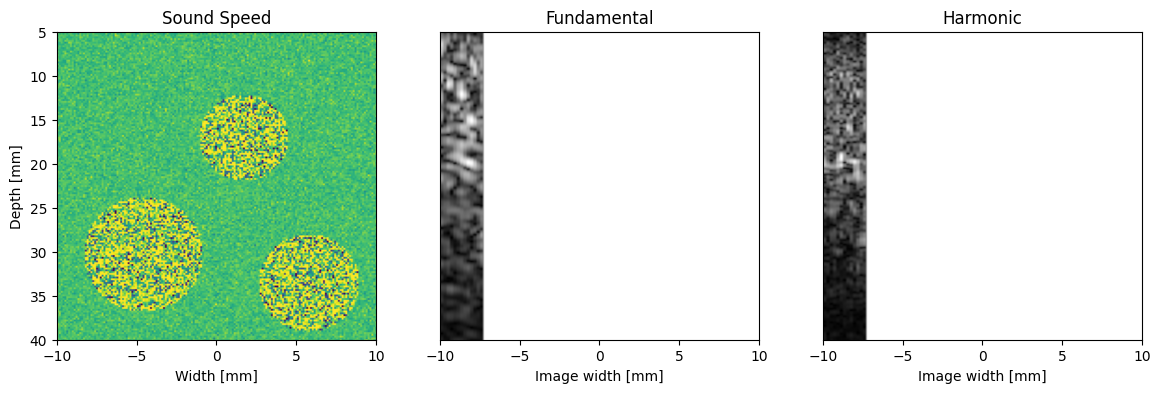

In [17]:
# Set the desired size of the image
image_size = kgrid.size

# Create the axis variables
x_axis = [0, image_size[0] * 1e3 * 1.1] # [mm]
y_axis = [-0.5 * image_size[1] * 1e3, 0.5 * image_size[1] * 1e3]  # [mm]

# make plotting non-blocking
plt.ion()
# Plot the data before and after scan conversion
plt.figure(figsize=(14, 4))
# plot the sound speed map
plt.subplot(1, 3, 1)
plt.imshow(sound_speed_map[:, 64:-64, int(grid_size_points.z / 2)], aspect='auto',
            extent=[y_axis[0], y_axis[1], x_axis[1], x_axis[0]])
plt.title('Sound Speed')
plt.xlabel('Width [mm]')
plt.ylabel('Depth [mm]')
ax = plt.gca()
ax.set_ylim(40, 5)
plt.subplot(1, 3, 2)
plt.imshow(scan_lines_fund.T, cmap='gray', aspect='auto',  extent=[y_axis[0], y_axis[1], x_axis[1], x_axis[0]])
plt.xlabel('Image width [mm]')
plt.title('Fundamental')
ax = plt.gca()
ax.set_ylim(40, 5)
plt.yticks([])
plt.subplot(1, 3, 3)
plt.imshow(scan_lines_harm.T, cmap='gray', aspect='auto', extent=[y_axis[0], y_axis[1], x_axis[1], x_axis[0]])
plt.yticks([])
plt.xlabel('Image width [mm]')
plt.title('Harmonic')
ax = plt.gca()
ax.set_ylim(40, 5)
plt.show()

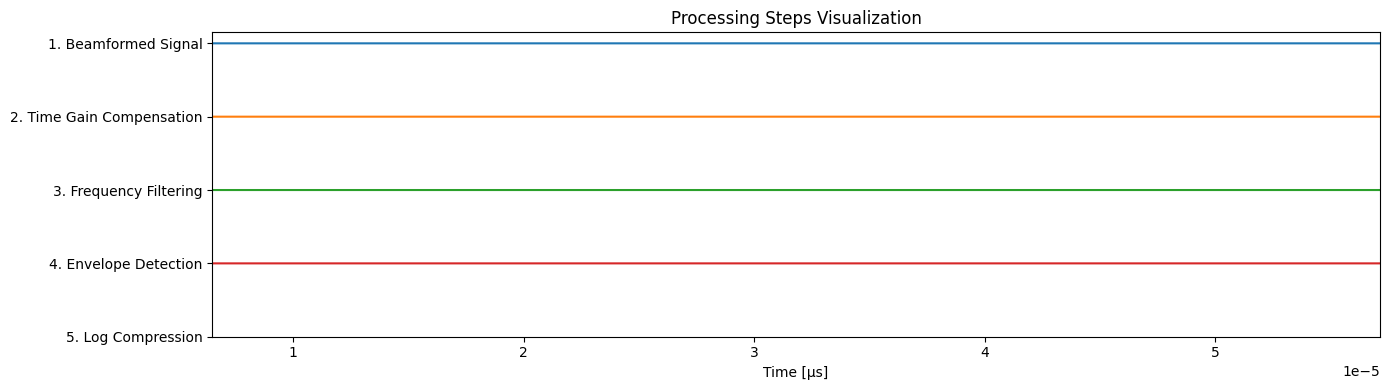

In [18]:
# Creating a dictionary with the step labels as keys
processing_steps = {
    '1. Beamformed Signal': scan_lines_no_input,
    '2. Time Gain Compensation': scan_lines_tgc,
    '3. Frequency Filtering': scan_lines_fund_ex,
    '4. Envelope Detection': scan_lines_fund_env_ex,
    '5. Log Compression': scan_lines_fund_log_ex
}

plt.figure(figsize=(14, 4), tight_layout=True)

offset = -6e5
# Plotting each step using the dictionary
for i, (label, data) in enumerate(processing_steps.items()):
    plt.plot(kgrid.t_array.squeeze(), data.squeeze() + offset * i, label=label)

# Set y-ticks and y-labels
plt.yticks([offset * i for i in range(5)], list(processing_steps.keys()))
plt.xlabel('Time [\u03BCs]')
plt.xlim(5e-3 * 2 / c0, t_end)
plt.title('Processing Steps Visualization')
plt.show()
